In [ ]:
#Installing libraries
!pip install -q datasets
!pip install -q transformers
!pip install -q rouge_score
!pip install -q evaluate

In [ ]:
import pandas as pd
import nltk
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_metric, Dataset
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
rouge_score = evaluate.load("rouge")

In [ ]:
df = pd.read_json('/train_spider.json')

In [ ]:
df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'from': {'table_units': [['table_unit', 1]], ..."
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'from': {'table_units': [['table_unit', 1]], ..."
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'from': {'table_units': [['table_unit', 0]], ..."
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'from': {'table_units': [['table_unit', 0]], ..."
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'from': {'table_units': [['table_unit', 0]], ..."


<ipython-input-6-62d29c00da53>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(l)


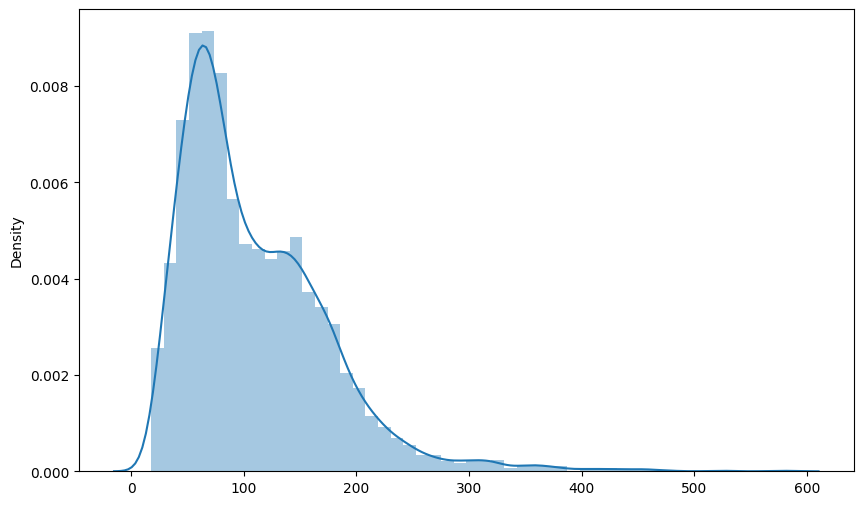

In [ ]:
# Checking the sequence lengths for queries in dataset
l = []
for i in df['query']:
  l.append(len(i))

plt.figure(figsize = (10,6))
sns.distplot(l)
plt.show()

<ipython-input-7-ed058b0e7704>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(l)


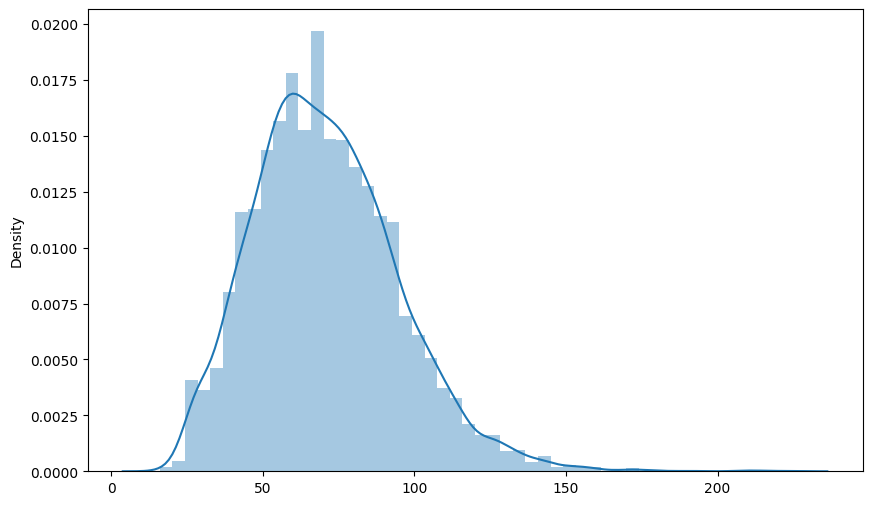

In [ ]:
# Checking the sequence length for questions in the dataset
l = []
for i in df['question']:
  l.append(len(i))

plt.figure(figsize = (10,6))
sns.distplot(l)
plt.show()

In [ ]:
df = df[['query','question']]

In [ ]:
df

,query,question
0,SELECT count(*) FROM head WHERE age > 56,How many heads of the departments are older th...
1,"SELECT name , born_state , age FROM head ORD...","List the name, born state and age of the heads..."
2,"SELECT creation , name , budget_in_billions ...","List the creation year, name and budget of eac..."
3,"SELECT max(budget_in_billions) , min(budget_i...",What are the maximum and minimum budget of the...
4,SELECT avg(num_employees) FROM department WHER...,What is the average number of employees of the...
...,...,...
6995,SELECT T1.company_name FROM culture_company AS...,What are all the company names that have a boo...
6996,"SELECT T1.title , T3.book_title FROM movie AS...",Show the movie titles and book titles for all ...
6997,"SELECT T1.title , T3.book_title FROM movie AS...",What are the titles of movies and books corres...
6998,SELECT T2.company_name FROM movie AS T1 JOIN c...,Show all company names with a movie directed i...


In [ ]:
# Splitting the dataset into training and validation set
train_df, val_df = train_test_split(df,test_size = 0.2, random_state = 21)
print(train_df.shape)
print(val_df.shape)

(5600, 2)
(1400, 2)


In [ ]:
# Converting the pandas dataframe to huggingface datasets and drooping the index columns generated
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['query', 'question'],
    num_rows: 5600
})
Dataset({
    features: ['query', 'question'],
    num_rows: 1400
})


In [ ]:
train_dataset['query'][1]

'SELECT Name FROM member WHERE Member_ID NOT IN (SELECT Member_ID FROM round)'

In [ ]:
# downloading model from the checkpoint
from transformers import AutoTokenizer
model_checkpoint = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# Preprocessing and defining the sequence length for training the models
max_input_length = 256
max_target_length = 256


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples['question'],
        max_length=max_input_length,
        truncation=True, padding = 'max_length'
    )
    labels = tokenizer(text_target = examples['query'], max_length=max_target_length, truncation=True,padding = 'max_length')
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["labels_mask"] = labels["attention_mask"]
    return model_inputs

In [ ]:
tokenized_train_datasets = train_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/5600 [00:00<?, ? examples/s]

In [ ]:
tokenized_val_datasets = val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_datasets = tokenized_train_datasets.remove_columns(['query','question'])
tokenized_val_datasets = tokenized_val_datasets.remove_columns(['query','question'])

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
data_collator = DataCollatorForSeq2Seq(model = model,tokenizer = tokenizer,label_pad_token_id=-100)

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install transformers[torch] accelerate>=0.20.1


In [ ]:
from transformers import Seq2SeqTrainingArguments
batch_size = 8
learning_rate = 1e-5
args = Seq2SeqTrainingArguments(
    "test-summary",
    evaluation_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=False,
    push_to_hub = False
)

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_val_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.525400,0.072043,49.587000,33.053800,44.560100,44.574500
2,0.065200,0.056727,52.741300,37.186100,48.214800,48.179800
3,0.039500,0.054500,52.542200,37.474000,48.129000,48.098800


TrainOutput(global_step=2100, training_loss=0.16368470191955567, metrics={'train_runtime': 5548.6804, 'train_samples_per_second': 3.028, 'train_steps_per_second': 0.378, 'total_flos': 9101839328870400.0, 'train_loss': 0.16368470191955567, 'epoch': 3.0})

In [ ]:
model.save_pretrained('vvn/Text_to_SQL_BART_spider-three-ep',push_to_hub=True)
tokenizer.save_pretrained('vvn/Text_to_SQL_BART_spider-three-ep',push_to_hub=True)

Configuration saved in vvn/Text_to_SQL_BART_spider-three-ep/config.json
Model weights saved in vvn/Text_to_SQL_BART_spider-three-ep/pytorch_model.bin
Uploading the following files to vvn/Text_to_SQL_BART_spider-three-ep: pytorch_model.bin,config.json
tokenizer config file saved in vvn/Text_to_SQL_BART_spider-three-ep/tokenizer_config.json
Special tokens file saved in vvn/Text_to_SQL_BART_spider-three-ep/special_tokens_map.json
Uploading the following files to vvn/Text_to_SQL_BART_spider-three-ep: tokenizer.json,vocab.json,tokenizer_config.json,merges.txt,special_tokens_map.json


('vvn/Text_to_SQL_BART_spider-three-ep/tokenizer_config.json',
 'vvn/Text_to_SQL_BART_spider-three-ep/special_tokens_map.json',
 'vvn/Text_to_SQL_BART_spider-three-ep/vocab.json',
 'vvn/Text_to_SQL_BART_spider-three-ep/merges.txt',
 'vvn/Text_to_SQL_BART_spider-three-ep/added_tokens.json',
 'vvn/Text_to_SQL_BART_spider-three-ep/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_checkpoint = "vvn/Text_to_SQL_BART_spider-three-ep"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
import torch

In [ ]:

def generate_sql_query(input_question):
    inputs = tokenizer(input_question, return_tensors="pt", padding=True)
    with torch.no_grad():
        model_output = model.generate(**inputs)
    decoded_query = tokenizer.decode(model_output[0], skip_special_tokens=True)
    return decoded_query


In [ ]:
input_questions = [
    "How many students scored above 90 in the English exam?",
    "List the names and ages of the department heads.",
    "What is the average number of employees in each department?",
]

for question in input_questions:
    generated_query = generate_sql_query(question)
    print(f"Question: {question}")
    print(f"Generated SQL Query: {generated_query}\n")


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (142) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Question: How many students scored above 90 in the English exam?
Generated SQL Query: SELECT count(*) FROM student AS T1 JOIN ENROLLED_IN AS T2 ON T1.student_id  =  T2.enroll_id JOIN exam AS T3 ON T3.exam_id = T4.examination_id WHERE T2's  grade  >  90 AND T3's  language  = 'English'

Question: List the names and ages of the department heads.
Generated SQL Query: SELECT T1.DName,  T2.Age FROM department AS T1 JOIN department_head AS T2 ON T1's department_id = T2's_department_head_id JOIN employee AS T3 ON T2 JOIN student AS T4 ON T3.Employee_ID  =  T4.Department_ID

Question: What is the average number of employees in each department?
Generated SQL Query: SELECT avg(Employee_count),  dept_name FROM employees GROUP BY department_name ORDER BY count(*) DESC LIMIT 1,  department_id GROUP BY DEPARTMENT_name GROUP BY Dept_code HAVING COUNT(*)  >=  1



In [ ]:
evaluation_data = [
    {"question": "How many students scored above 90 in the English exam?", "gold_sql": "SELECT COUNT(*) FROM students WHERE exam = 'English' AND score > 90;"},
    {"question": "List the names and ages of the department heads.", "gold_sql": "SELECT name, age FROM department_heads;"},
    {"question": "What is the average number of employees in each department?", "gold_sql": "SELECT department, AVG(employees) FROM department_employees GROUP BY department;"}
    # Add more input question and gold-standard SQL pairs as needed
]
generated_sql_queries = []
for data in evaluation_data:
    generated_query = generate_sql_query(data["question"])
    generated_sql_queries.append(generated_query)


In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

gold_standard_queries = [data["gold_sql"] for data in evaluation_data]
rouge_scores = []
for i in range(len(generated_sql_queries)):
    rouge_score = scorer.score(generated_sql_queries[i], gold_standard_queries[i])
    rouge_scores.append(rouge_score)


In [ ]:
for i in range(len(generated_sql_queries)):
    print(f"Question: {evaluation_data[i]['question']}")
    print(f"Generated SQL: {generated_sql_queries[i]}")
    print(f"Gold SQL: {evaluation_data[i]['gold_sql']}")
    print("ROUGE Scores:", rouge_scores[i], "\n")


Question: How many students scored above 90 in the English exam?
Generated SQL: SELECT count(*) FROM student AS T1 JOIN ENROLLED_IN AS T2 ON T1.student_id  =  T2.enroll_id JOIN exam AS T3 ON T3.exam_id = T4.examination_id WHERE T2's  grade  >  90 AND T3's  language  = 'English'
Gold SQL: SELECT COUNT(*) FROM students WHERE exam = 'English' AND score > 90;
ROUGE Scores: {'rouge1': Score(precision=0.9, recall=0.23076923076923078, fmeasure=0.3673469387755102), 'rouge2': Score(precision=0.3333333333333333, recall=0.07894736842105263, fmeasure=0.12765957446808512), 'rougeL': Score(precision=0.6, recall=0.15384615384615385, fmeasure=0.2448979591836735)} 

Question: List the names and ages of the department heads.
Generated SQL: SELECT T1.DName,  T2.Age FROM department AS T1 JOIN department_head AS T2 ON T1's department_id = T2's_department_head_id JOIN employee AS T3 ON T2 JOIN student AS T4 ON T3.Employee_ID  =  T4.Department_ID
Gold SQL: SELECT name, age FROM department_heads;
ROUGE Scores